# **Kooplearn for Transfer Operator Learning**

---

In [1]:
import importlib

for module in ['kooplearn', 'matplotlib']:
    try:
        importlib.import_module(module)
    except ImportError:
        %pip install {module}

## **Toy Example: Logistic Map**

In [2]:
from kooplearn.datasets import LogisticMap

# Defining the number of samples for each data split
train_samples = 50000 
test_samples = 1000

logmap = LogisticMap(N = 20, rng_seed = 0, r=4.0) # Setting the rng_seed for reproducibility

initial_condition = 0.5 # Setting the initial condition x_0 to start sampling the map

datasets = {
    'train': logmap.sample(initial_condition, train_samples),
    'test': logmap.sample(initial_condition, test_samples)
}

for split, ds in datasets.items():
    print(f"{split.capitalize()} split has shape {ds.shape}")

Train split has shape (50001, 1)
Test split has shape (1001, 1)


we have one more point and it is for the initial value.

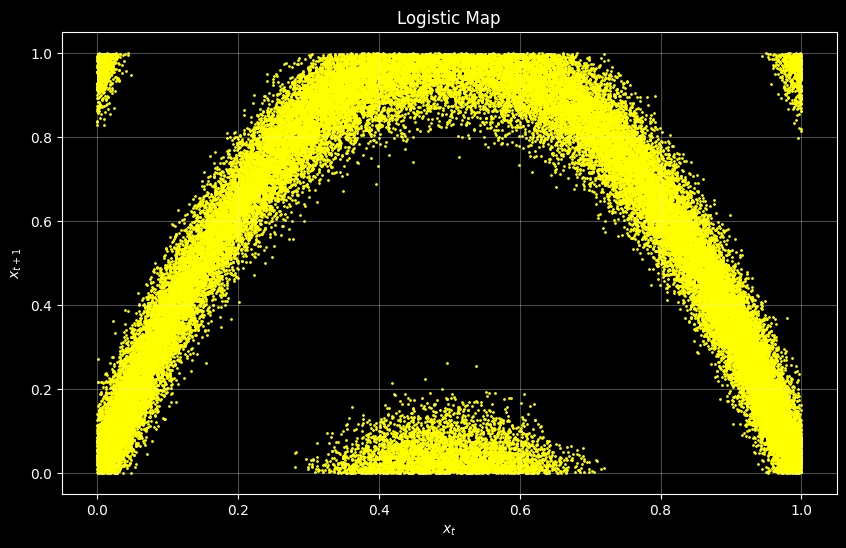

In [3]:
# plot the data points in the train split as scatter points
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.figure(figsize=(10, 6))
plt.grid(alpha=0.3)
plt.scatter(datasets['train'][:-1], datasets['train'][1:], s=1, c='yellow')
plt.xlabel(r'$x_t$')
plt.ylabel(r'$x_{t+1}$')
plt.title('Logistic Map')



plt.show()

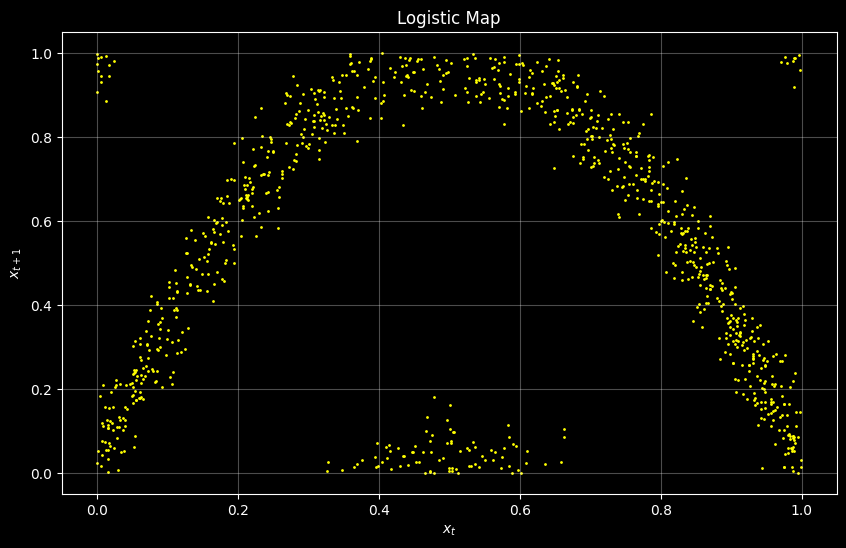

In [4]:
# plot the data points in the test split as scatter points
plt.figure(figsize=(10, 6))
plt.grid(alpha=0.3)
plt.scatter(datasets['test'][:-1], datasets['test'][1:], s=1, c='yellow')
plt.xlabel(r'$x_t$')
plt.ylabel(r'$x_{t+1}$')
plt.title('Logistic Map')

plt.show()

In [5]:
# ploting the variation of x with the parameter r
import numpy as np
from tqdm.notebook import tqdm

def logistic_map(x, y):
	'''a function to calculate the next step of the discrete map.  Inputs
	x and y are transformed to x_next, y_next respectively'''
	y_next = y * x * (1 - y)
	x_next = x + 0.0000001
	yield x_next, y_next
	
steps = 30000000

Y = np.zeros(steps + 1)
X = np.zeros(steps + 1)

X[0], Y[0] = 1, 0.5

# map the equation to array step by step using the logistic_map function above
for i in tqdm(range(steps)):
	x_next, y_next = next(logistic_map(X[i], Y[i])) # calls the logistic_map function on X[i] as x and Y[i] as y
	X[i+1] = x_next
	Y[i+1] = y_next
	


  0%|          | 0/30000000 [00:00<?, ?it/s]

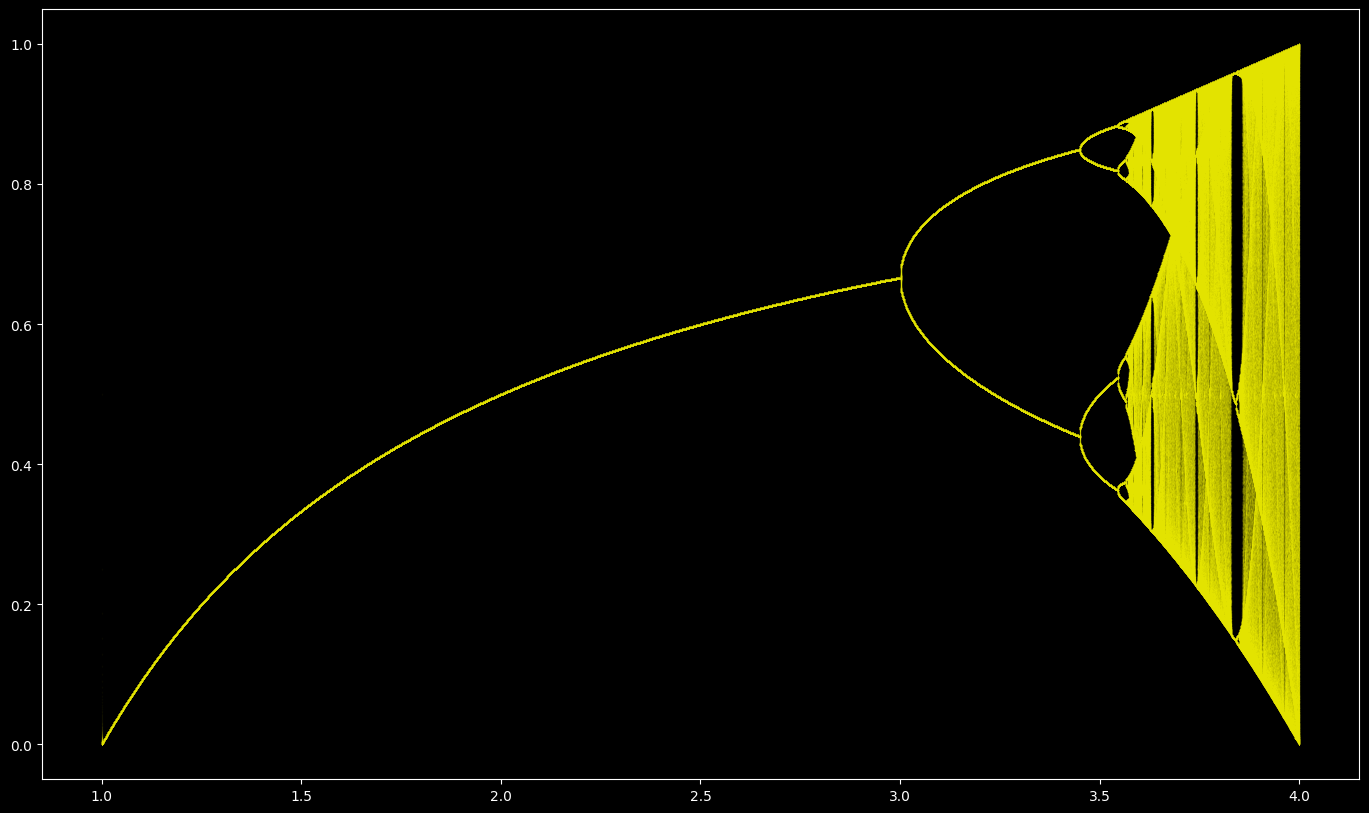

In [6]:
plt.style.use('dark_background')
plt.figure(figsize=(17, 10))
plt.plot(X, Y, '^', color='yellow', alpha=0.8, markersize = 0.009)
plt.axis('on')
plt.show()

    - Training using Chebychev polynomials

In [7]:
import numpy as np
import scipy.special
from kooplearn.abc import FeatureMap

class ChebyshevPoly(FeatureMap):
    def __init__(self, max_order: int = 10):
        self.max_order = max_order # Will take polynomials up to order max_order (excluded)
    
    def __call__(self, data: np.ndarray):
        x = 2 * data - 1 # Transform the input data (defined on [0, 1]) to the interval [-1, 1] over which the Chebyshev polynomials are defined.
        phi = np.concatenate([scipy.special.eval_chebyt(n, x) for n in range(self.max_order)], axis=-1) # Evaluate the Chebyshev polynomials up to max_order
        return phi

In [8]:
feature_map = ChebyshevPoly(max_order = 4)

print(f"The first 5 training points are\n{datasets['train'][:5]}\nTheir feature map is\n{feature_map(datasets['train'][:5])}")

The first 5 training points are
[[0.5       ]
 [0.02461448]
 [0.05297965]
 [0.07993305]
 [0.14713471]]
Their feature map is
[[ 1.          0.         -1.         -0.        ]
 [ 1.         -0.95077105  0.80793118 -0.5855441 ]
 [ 1.         -0.89404071  0.59861757 -0.17633624]
 [ 1.         -0.84013391  0.41164997  0.14845172]
 [ 1.         -0.70573058 -0.00388869  0.71121932]]


In [9]:
from kooplearn.models import Nonlinear

feature_map = ChebyshevPoly(max_order = 10) # We choose a max_order of 10, which is appropriate for this problem (See the DPNets paper by Kostic et al. for more details)
model = Nonlinear(feature_map, tikhonov_reg=1e-6) # We set the Tikhonov regularization parameter to 1e-6

In [10]:
from kooplearn.data import traj_to_contexts

contexts = {k: traj_to_contexts(v) for k, v in datasets.items()} # Converting the trajectories to contexts
for split, ds in contexts.items():
    print(f"{split.capitalize()} contexts have shape {ds.shape}: {len(ds)} contexts of length {ds.context_length} with {ds.shape[2]} features each")

Train contexts have shape (50000, 2, 1): 50000 contexts of length 2 with 1 features each
Test contexts have shape (1000, 2, 1): 1000 contexts of length 2 with 1 features each


In [11]:
model.fit(contexts['train'])

Evaluating the model 

We conclude by evaluating the model on two different tasks

- Predicting the next expected state by using model.predict()

- Approximating the eigenvalues of the transfer operator via model.eig()

In [12]:
from sklearn.metrics import mean_squared_error

def prediction_error(model, contexts):
    pred_frames = np.squeeze(model.predict(contexts)) # Predicting the future frames
    true_frames = np.squeeze(contexts.lookforward(model.lookback_len)) # everything after the lookback length (i.e. the lookforward window)
    return mean_squared_error(true_frames, pred_frames)

for split, ds in contexts.items():
    print(f"Prediction error for {split.lower()}: {prediction_error(model, ds):.4f}")

Prediction error for train: 0.0589
Prediction error for test: 0.0580


In [13]:
true_eigs = logmap.eig()
pred_eigs = model.eig()

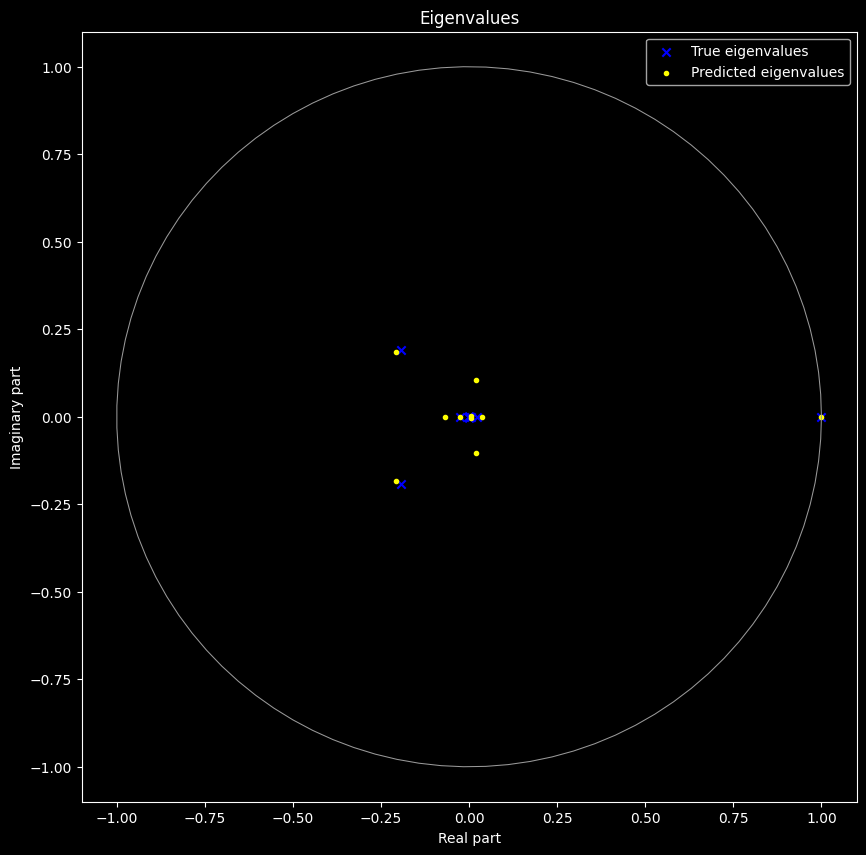

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(true_eigs.real, true_eigs.imag, label='True eigenvalues', marker='x', color='blue')
ax.scatter(pred_eigs.real, pred_eigs.imag, label='Predicted eigenvalues', marker = '.', color='yellow')
# Plot unit circle
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), linestyle='-', color='#999', lw=0.75)

ax.set_xlabel('Real part')
ax.set_ylabel('Imaginary part')
ax.set_title('Eigenvalues')
ax.legend()
plt.show()


Projection matrix : (10, 10)
 UUT : (10, 10)
Learned operator : (10, 10)


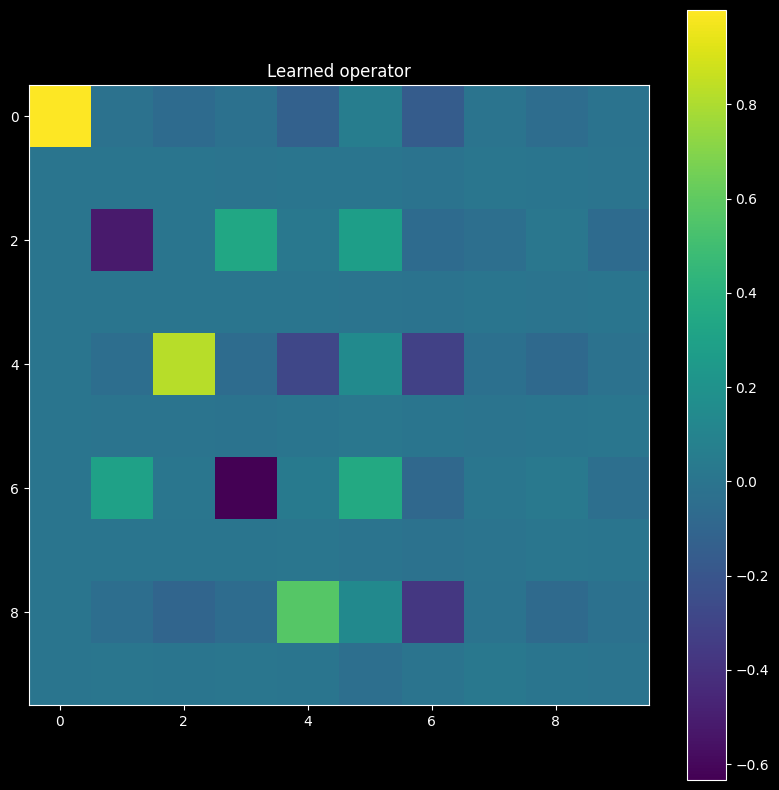

In [15]:
# plot the learnt operator
import matplotlib.pyplot as plt
#Attributes:
    # data_fit : Training data, of type kooplearn.data.TensorContextDataset.
    # cov_X : Covariance matrix of the feature map evaluated at the initial states, that is self.data_fit.lookback(self.lookback_len).
    # cov_Y : Covariance matrix of the feature map evaluated at the evolved states, , that is self.data_fit.lookback(self.lookback_len, slide_by = 1).
    # cov_XY : Cross-covariance matrix between initial and evolved states.
    # U : Projection matrix of shape (n_out_features, rank). The Koopman/Transfer operator is approximated as U U^T \mathrm{cov_{XY}}.

projection_mat = model.U
print(f"Projection matrix : {projection_mat.shape}")
T_hat = np.dot(projection_mat, projection_mat.T)
print(f" UUT : {T_hat.shape}")
T_hat = T_hat @ model.cov_XY
print(f"Learned operator : {T_hat.shape}")

plt.figure(figsize=(10, 10))
plt.imshow(T_hat)
plt.title('Learned operator')
plt.colorbar()

plt.show()

----

## **Application on RL problems**

The paper of the POWR algorithm is using a Transfer Operator Learning to estimate the action-value function in Reinforcement Learning problems.

We will use Kooplearn library to learn the transfer operator related to the FrozenLake environment.

In [1]:
import gym
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from kooplearn.abc import FeatureMap
from kooplearn.models import Nonlinear
from kooplearn.data import traj_to_contexts
import torch
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)


In [2]:
# get the State set and Action set and the Transition matrix
S = env.observation_space
A = env.action_space
P = np.zeros((S.n, A.n, S.n)) # Transition matrix
for s in range(S.n):
    for a in range(A.n):
        for prob, next_state, reward, done in env.env.P[s][a]:
            P[s, a, next_state] += prob
        

# normalize the transition matrix
P /= P.sum(axis=-1, keepdims=True)


In [3]:
S, A

(Discrete(16), Discrete(4))

In [4]:
P.shape

(16, 4, 16)

In [5]:
def collect_trajectories(env, policy, num_episodes):
    trajectories = []
    for _ in range(num_episodes):
        state = env.reset()
        done = False
        episode = []
        while not done:
            action = policy(state)  # Define a simple policy or use random actions
            next_state, reward, done, _, _= env.step(action)
            episode.append((state, action, reward, next_state))
            state = next_state
        trajectories.append(episode)
    return trajectories

def collect_transitions(env, policy, num_transitions=10000):
    transitions = []
    state = env.reset()
    for _ in tqdm(range(num_transitions)):
        if isinstance(state, tuple):
            state = state[0] # Unpack the state if it is a tuple
        action = policy(state)
        next_state, reward, done, _, _ = env.step(action)
        if isinstance(next_state, tuple):
            next_state = next_state[0] # Unpack the next_state if it is a tuple
        transitions.append((state, action, next_state))
        if done:
            state = env.reset()
        else:
            state = next_state
    return transitions

def random_policy(state):
    return np.random.choice(A.n)

In [6]:
# Collect trajectories
num_episodes = 5  # Number of episodes to collect
#trajectories = collect_trajectories(env, random_policy, num_episodes)
transitions = collect_transitions(env, random_policy, num_transitions=100)

# Example to view the collected trajectories
# for i, trajectory in enumerate(trajectories):
#     print(f"Trajectory {i+1}:")
#     for state, action, reward, next_state in trajectory:
#         print(f"State: {state}, Action: {action}, Reward: {reward}, Next State: {next_state}")
#     print()

  0%|          | 0/100 [00:00<?, ?it/s]

/home/infres/zakil-22/Policy-mirror-descent-with-Operator-World-models-for-Rl/myenv/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [7]:
class StateFeatureMap(FeatureMap):
    def __call__(self, data: np.ndarray):
        # Simple one-hot encoding for the state feature map
        data_int = np.asarray(data, dtype=np.int32)
        return np.eye(env.observation_space.n)[data_int]

class ActionFeatureMap(FeatureMap):
    def __call__(self, data: np.ndarray):
        # Simple one-hot encoding for the action feature map
        data_int = np.asarray(data, dtype=np.int32)
        return np.eye(env.action_space.n)[data_int]

In [8]:
# Step 4: Set up kooplearn model
state_feature_map = StateFeatureMap()
action_feature_map = ActionFeatureMap()

# Converting transitions into contexts for kooplearn
states, actions, next_states = zip(*transitions)

# print(states)
# print(actions)
# print(next_states)
states = np.array(states, dtype=int)        # Ensure arrays are of homogeneous type
actions = np.array(actions, dtype=int)
next_states = np.array(next_states, dtype=int)

from scipy.sparse import csr_matrix
state_features = state_feature_map(states)
action_features = action_feature_map(actions)
next_state_features = state_feature_map(next_states) # We use the same feature map for the next states as for the current states

# Using a nonlinear model with specified feature maps
model = Nonlinear(state_feature_map, tikhonov_reg=1e-6)

# Preparing the context data for kooplearn
# Combine states and actions into a single feature vector
combined_features = np.concatenate([state_features, action_features], axis=1)
contexts = traj_to_contexts(combined_features)

In [9]:
contexts.shape

(99, 2, 20)

In [10]:
combined_features.shape # (n_frames, features_shape)

(100, 20)

In [11]:
# Step 5: Train the model
from kooplearn.data import TensorContextDataset
torch_contexts = torch.tensor(combined_features, dtype=torch.float32).unsqueeze(0)
tensor_contexts = TensorContextDataset(torch_contexts)


In [12]:
tensor_contexts.shape

torch.Size([1, 100, 20])

In [13]:
# Patch training data to the model

batch = 10

for i in tqdm(range(0, tensor_contexts.shape[1], batch)):
    model.fit(tensor_contexts[:, i:i+batch, :])

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
# Evaluate the learned transfer operator (Optional: visualize or inspect)
T_hat = np.dot(model.U, model.U.T) @ model.cov_XY
print(f"Learned transfer operator shape: {T_hat.shape}")

Learned transfer operator shape: (2880, 2880)


In [15]:
from sklearn.metrics import mean_squared_error

def prediction_error(model, contexts):
    pred_frames = np.squeeze(model.predict(contexts)) # Predicting the future frames
    true_frames = np.squeeze(contexts.lookforward(model.lookback_len)) # everything after the lookback length (i.e. the lookforward window)
    return mean_squared_error(true_frames, pred_frames)


In [17]:
batch = 10
errors = []
torch_contexts = torch.tensor(combined_features, dtype=torch.int32).unsqueeze(0)
tensor_contexts = TensorContextDataset(torch_contexts)
for i in range(0, tensor_contexts.shape[1], batch):
    error = prediction_error(model, tensor_contexts[:,i:i+batch,:])
    print(f"Prediction error: {error:.4f}")
    errors.append(error)

Prediction error: 0.1732
Prediction error: 0.1694
Prediction error: 0.1732
Prediction error: 0.0840
Prediction error: 0.1732
Prediction error: 0.1713
Prediction error: 0.1713
Prediction error: 0.1732
Prediction error: 0.1658
Prediction error: 0.0000


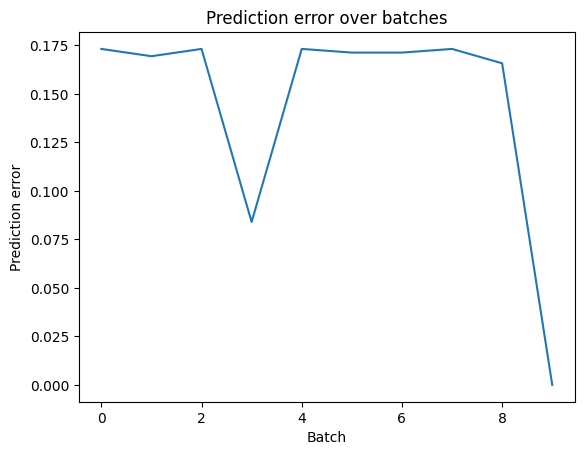

In [18]:
# Plot the prediction error
plt.plot(errors)
plt.xlabel('Batch')
plt.ylabel('Prediction error')
plt.title('Prediction error over batches')
plt.show()